# Wear Prediction Using Regression and Classification Models

This notebook explains step-by-step how a machine learning pipeline is implemented to predict tool wear based on drilling parameters. It also interprets model evaluation metrics.

## 1. Load Libraries and Dataset
We import necessary Python libraries and load the dataset used for both regression and classification.

In [14]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

file_path = r"XAI_Drilling_Dataset.csv"
df = pd.read_csv(file_path)
    

In [6]:
from pathlib import Path
import pandas as pd

# Current working directory (notebook location)
BASE_DIR = Path.cwd()
file_path = BASE_DIR.parent / "Dataset/XAI_Drilling_Dataset.csv"
print(file_path)

df = pd.read_csv(file_path)

print(df.head())

/home/myuser/TUM/sl-siemens/FINAL/Dataset/XAI_Drilling_Dataset.csv
   ID  Cutting speed vc [m/min]  Spindle speed n [1/min]  Feed f [mm/rev]  \
0   1                     29.92                      794            0.218   
1   2                     29.85                      792            0.241   
2   3                     22.85                      606            0.183   
3   4                     29.60                      785            0.236   
4   5                     17.43                      462            0.246   

   Feed rate vf [mm/min]  Power Pc [kW]  Cooling [%] Material Drill Bit Type  \
0                    173         194.87           75        N              W   
1                    191         214.71           75        N              W   
2                    111          95.68           50        P              N   
3                    237         206.93           75        N              W   
4                    114          74.85           50        K         

## 2. Feature Engineering
We create new columns 'Torque', 'Tf', and assign fixed hardness values by material.

In [15]:

df['Torque'] = (9550 * df['Power Pc [kW]']) / df['Spindle speed n [1/min]']
df['Tf'] = df['Torque'] / df['Feed f [mm/rev]']
material_hardness = {'N': 70, 'P': 180, 'K': 160}
df['Hardness'] = df['Material'].map(material_hardness)
df.head()
    

,ID,Cutting speed vc [m/min],Spindle speed n [1/min],Feed f [mm/rev],Feed rate vf [mm/min],Power Pc [kW],Cooling [%],Material,Drill Bit Type,Process Time [sec],Main Failure,BEF,CCF,FWF,WDF,Torque,Tf,Hardness
0,1,29.92,794,0.218,173,194.87,75,N,W,19.26,0,0,0,0,0,2343.839421,10751.556975,70
1,2,29.85,792,0.241,191,214.71,75,N,W,19.55,0,0,0,0,0,2588.990530,10742.699296,70
2,3,22.85,606,0.183,111,95.68,50,P,N,36.16,0,0,0,0,0,1507.828383,8239.499360,180
3,4,29.60,785,0.236,237,206.93,75,N,W,21.22,1,0,0,1,0,2517.428662,10667.070603,70
4,5,17.43,462,0.246,114,74.85,50,K,H,33.56,0,0,0,0,0,1547.224026,6289.528561,160


## 3. Visualization of Original Data (Without SMOTE or Normalization)
We visualize the real data before any processing, including calculated classes.

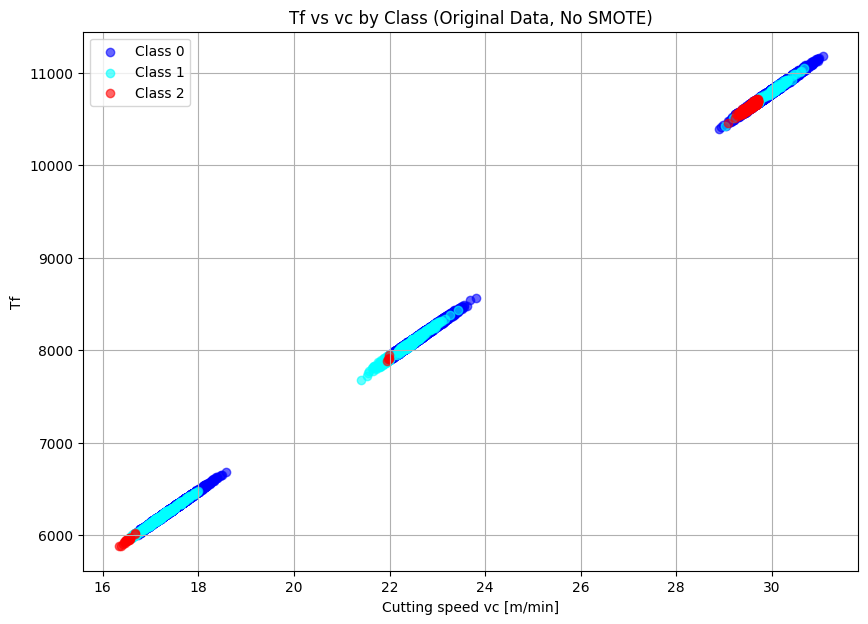

In [16]:
vc_min = df[df['FWF'] == 1]['Cutting speed vc [m/min]'].min()
tf_min = df[df['FWF'] == 1]['Tf'].min()

def classify_zone(row):
    if (row['Cutting speed vc [m/min]'] <= vc_min) or (row['Tf'] <= tf_min):
        return 2
    elif row['FWF'] == 1:
        return 2
    elif row['FWF'] == 0 and row['Main Failure'] == 1:
        return 1
    else:
        return 0

df['Zone_3Class'] = df.apply(classify_zone, axis=1)

plt.figure(figsize=(10, 7))
colors = {0: 'blue', 1: 'cyan', 2: 'red'}
for label in sorted(df['Zone_3Class'].unique()):
    subset = df[df['Zone_3Class'] == label]
    plt.scatter(subset['Cutting speed vc [m/min]'], subset['Tf'], color=colors[label], alpha=0.6, label=f'Class {label}')
plt.xlabel('Cutting speed vc [m/min]')
plt.ylabel('Tf')
plt.legend()
plt.grid(True)
plt.title('Tf vs vc by Class (Original Data, No SMOTE)')
plt.show()


## 4. Training Models per Material
For each material type, we train:
- A Linear Regression model for Torque prediction.
- An XGBoost Classifier for predicting wear zones (3 classes).
We use SMOTE to balance class distribution.

Classification report for material N:
              precision    recall  f1-score   support

           0       0.76      0.55      0.64      1256
           1       0.69      0.75      0.72      1256
           2       0.84      1.00      0.91      1257

    accuracy                           0.77      3769
   macro avg       0.76      0.77      0.76      3769
weighted avg       0.76      0.77      0.76      3769



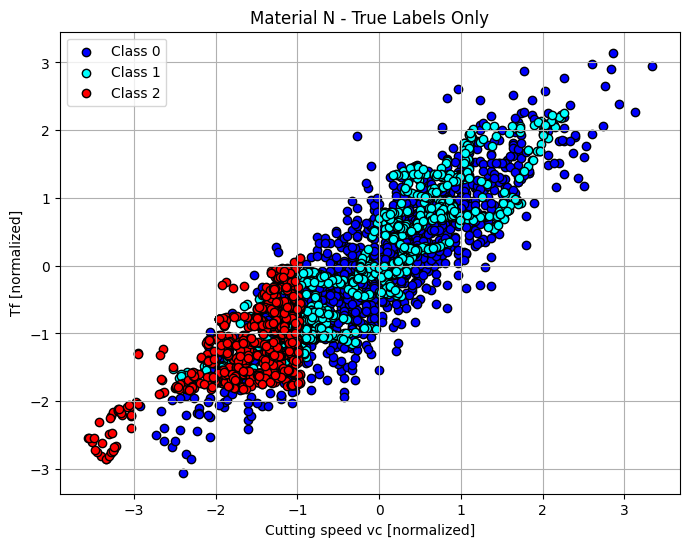

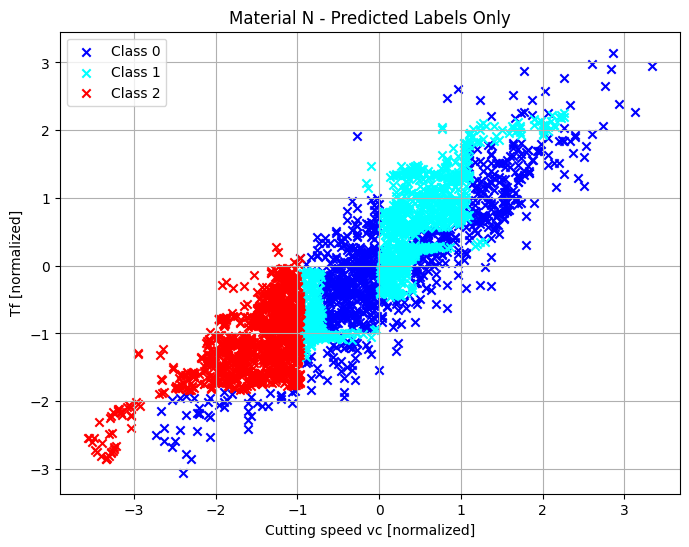

Classification report for material P:
              precision    recall  f1-score   support

           0       0.72      0.85      0.78      1265
           1       0.80      0.67      0.73      1266
           2       1.00      0.97      0.99      1266

    accuracy                           0.83      3797
   macro avg       0.84      0.83      0.83      3797
weighted avg       0.84      0.83      0.83      3797



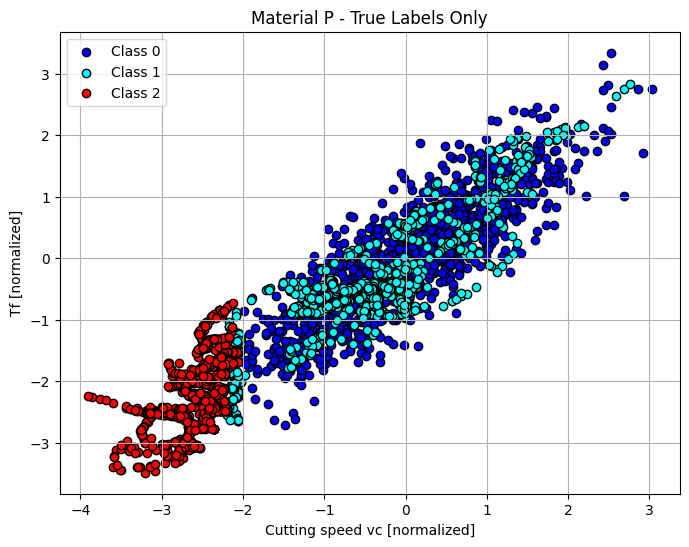

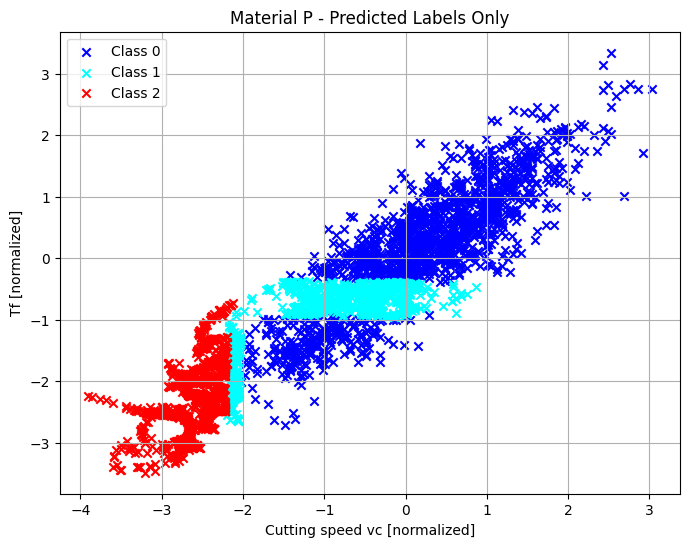

Classification report for material K:
              precision    recall  f1-score   support

           0       0.72      0.83      0.77      1277
           1       0.76      0.68      0.71      1277
           2       0.99      0.95      0.97      1277

    accuracy                           0.82      3831
   macro avg       0.83      0.82      0.82      3831
weighted avg       0.83      0.82      0.82      3831



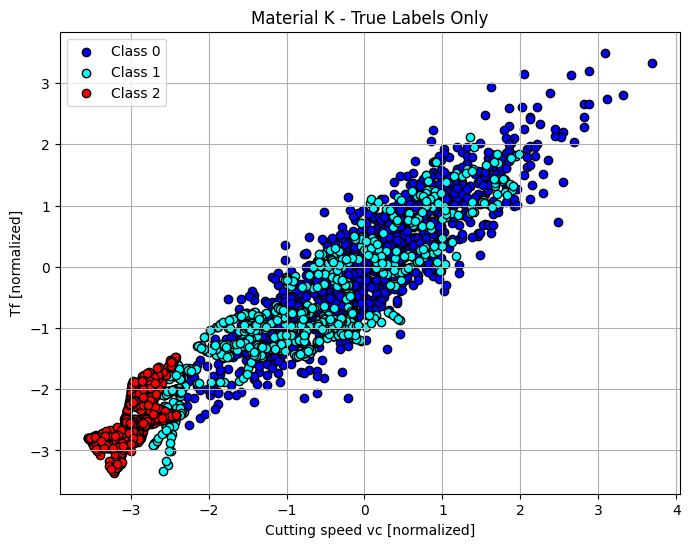

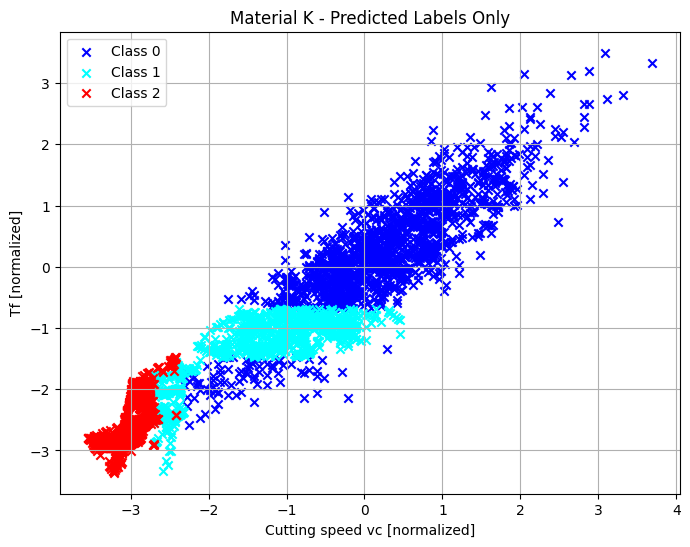

In [17]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

regressors = {}
classifiers = {}
scalers = {}

for material in df['Material'].unique():
    subset = df[df['Material'] == material].copy()
    regressor = LinearRegression()
    X_reg = subset[['Hardness', 'Feed f [mm/rev]']].values
    y_reg = subset['Torque'].values
    regressor.fit(X_reg, y_reg)
    regressors[material] = regressor

    def classify_zone(row):
        if (row['Cutting speed vc [m/min]'] <= subset[subset['FWF'] == 1]['Cutting speed vc [m/min]'].min()) or (row['Tf'] <= subset[subset['FWF'] == 1]['Tf'].min()):
            return 2
        elif row['FWF'] == 1:
            return 2
        elif row['FWF'] == 0 and row['Main Failure'] == 1:
            return 1
        else:
            return 0

    subset['Zone_3Class'] = subset.apply(classify_zone, axis=1)
    X_class = subset[['Cutting speed vc [m/min]', 'Torque', 'Feed f [mm/rev]']].values
    y_class = subset['Zone_3Class'].values

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_class)
    smote = SMOTE(random_state=42)
    X_scaled, y_class = smote.fit_resample(X_scaled, y_class)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_class, test_size=0.2, random_state=42, stratify=y_class)
    model = XGBClassifier(objective='multi:softprob', num_class=3, eval_metric='mlogloss', max_depth=3, n_estimators=20, learning_rate=0.2, use_label_encoder=False, verbosity=0, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f'Classification report for material {material}:')
    print(classification_report(y_test, y_pred))

    plt.figure(figsize=(8, 6))
    colors = {0: 'blue', 1: 'cyan', 2: 'red'}
    for label in np.unique(y_test):
        mask = y_test == label
        plt.scatter(X_test[mask, 0], X_test[mask, 1], color=colors[label], edgecolor='black', marker='o', label=f'Class {label}')
    plt.xlabel('Cutting speed vc [normalized]')
    plt.ylabel('Tf [normalized]')
    plt.title(f"Material {material} - True Labels Only")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(8, 6))
    for label in np.unique(y_pred):
        mask = y_pred == label
        plt.scatter(X_test[mask, 0], X_test[mask, 1], color=colors[label], marker='x', label=f'Class {label}')
    plt.xlabel('Cutting speed vc [normalized]')
    plt.ylabel('Tf [normalized]')
    plt.title(f"Material {material} - Predicted Labels Only")
    plt.legend()
    plt.grid(True)
    plt.show()

    classifiers[material] = model
    scalers[material] = scaler

    

## 5. How to Interpret the Classification Report
Each report shows precision, recall, f1-score, support, and accuracy metrics for classes 0, 1, 2:

Class 0: Safe

Class 1: Warning

Class 2: Fail

What Each Metric Means:

- Precision: Out of all predicted instances of a class, how many were correct?
→ High precision → Few false positives.

- Recall (Sensitivity): Out of all actual instances of a class, how many did the model correctly identify?
→ High recall → Few false negatives.

- F1-score: Harmonic mean between precision and recall.
→ High F1-score → Good balance between precision and recall.

- Support: Number of real instances for each class in the test set.

- Accuracy: Total correct predictions divided by total predictions.
→ Be careful: If classes are unbalanced, accuracy can be misleading.

Macro Average vs. Weighted Average:
- Macro avg: Simple average across all classes. Treats all classes equally.

- Weighted avg: Average weighted by the number of instances per class. Reflects the true class distribution.

## 6. Example: Predicting Wear for a New Input
You can now use the trained models to predict wear for new inputs.

In [27]:

material_input = 'P'  # Example
feed = 0.2
vc = 100

hardness = material_hardness[material_input]
torque_pred = regressors[material_input].predict([[hardness, feed]])[0]
input_scaled = scalers[material_input].transform([[vc, torque_pred, feed]])
probs = classifiers[material_input].predict_proba(input_scaled)[0]
wear_estimated = probs[0] * 5 + probs[1] * 50 + probs[2] * 100

print(f"Predicted Torque: {torque_pred:.2f} Nm")
print(f"Estimated Wear: {wear_estimated:.1f}%")
print(f"Probabilities -> Safe: {probs[0]*100:.1f}%, Warning: {probs[1]*100:.1f}%, Fail: {probs[2]*100:.1f}%")
    

Predicted Torque: 1645.46 Nm
Estimated Wear: 14.5%
Probabilities -> Safe: 81.9%, Warning: 15.4%, Fail: 2.7%


# Saving MOdels, Regressors and Scalers

In [25]:
import joblib
import os

save_path = "saved_models"
os.makedirs(save_path, exist_ok=True)

# Save everything per material
for material in regressors:
    joblib.dump(regressors[material], f"{save_path}/regressor_{material}.pkl")
    joblib.dump(classifiers[material], f"{save_path}/classifier_{material}.pkl")
    joblib.dump(scalers[material], f"{save_path}/scaler_{material}.pkl")

print("✅ Models and scalers saved successfully.")


✅ Models and scalers saved successfully.
